In [1]:
from experiments import *

In [2]:
inputlist = ["Helheim_Weertman_iT080_PINN_fastflow_CF"]
outputlist = ["SSA2D_frictionuvsH_velmag"]

In [3]:
# inputlist = ["Helheim_Big_PINN_fastflow_obs_JoughinComposite", "Helheim_Big_PINN_fastflow_obs_ITSLIVE2007", "Helheim_Big_PINN_fastflow_obs_ITSLIVE0", "Helheim_Big_PINN_fastflow_obs_Rignot2012"]
# outputlist = ["SSA2D_frictionuvsH_Joughin", "SSA2D_frictionuvsH_ITSLIVE07", "SSA2D_frictionuvsH_ITSLIVE0", "SSA2D_frictionuvsH_Rignot12"]

Hyperparameters:
{
  "N_u": 4000,
  "N_f": 9000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "h_layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "C_layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    1
  ],
  "friction_layers": [
    3,
    20,
    20,
    20,
    20,
    20,
    20,
    1
  ],
  "tf_epochs": 400000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "log_frequency": 10000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.4.1
Eager execution: True
GPU-accerelated: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training started
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
minmax_scale_layer (MinmaxSc (None, 2)                 6         
_________________________________________________________________
dense (Dense

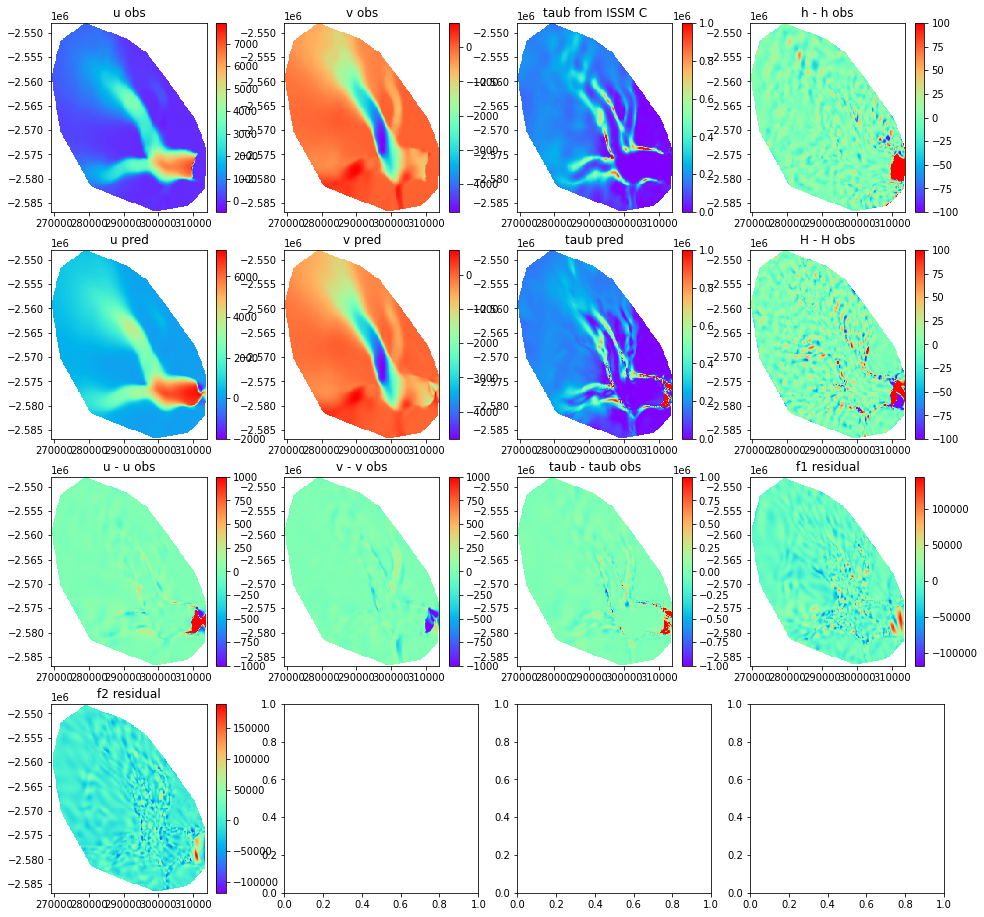

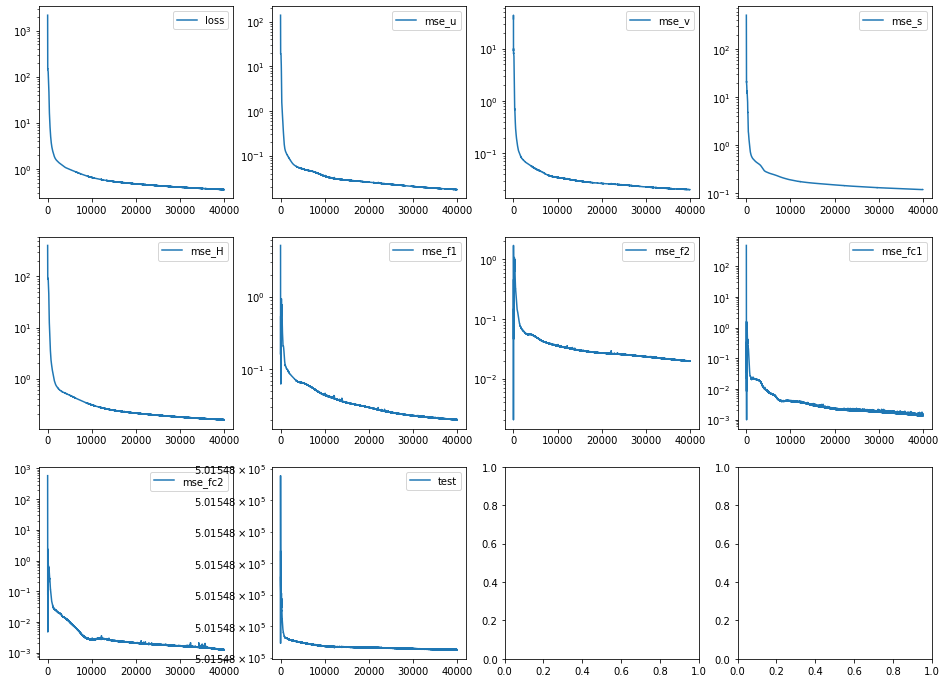

In [4]:
for i in range(len(inputlist)):
    experiment_2D_frictionNN_positivetau_velmag((5, 3, 5, 10, 16), seed=None, N_u=4000, N_f= 9000, NNeurons=20, NLayers=6, inputFileName=inputlist[i], outputFileName=outputlist[i])